# **Variational Quantum Eigensolver Method with Qiskit**

In [1]:
from qiskit import *
import numpy as np

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Define the Pauli matrices 
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-np.complex(0,1)],[np.complex(0,1),0]])
Z = np.array([[1,0],[0,-1]])

/tmp/ipykernel_1094/1870473614.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.array([[0,-np.complex(0,1)],[np.complex(0,1),0]])


In [3]:
# Compute the tensor product of the Pauli matrices

XX = np.kron(X,X)
YY = np.real(np.kron(Y,Y)) # This will be a real matrix
ZZ = np.kron(Z,Z)
II = np.identity(4)

print("The XX gate is: \n{} \n".format(XX))
print("The YY gate is: \n{} \n".format(YY))
print("The ZZ gate is: \n{} \n".format(ZZ))

The XX gate is: 
[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]] 

The YY gate is: 
[[ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]] 

The ZZ gate is: 
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]] 



In [4]:
# This is the decomposition of the "M" matrix 
M = (XX+YY+ZZ-II)/2
print('M = \n',M)
print('')

M = 
 [[ 0.  0.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  0.  0.]]



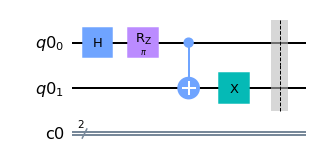

In [5]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.rz(theta,q[0])
circuit.cx(q[0],q[1])
circuit.x(q[1])
circuit.barrier()
circuit.draw()

In [6]:
def anzatz(circuit,q,c,theta):
    '''
    The Anzatz wave function
    |psi > = (I X)(CX)(Rz(theta) I)(H I)|00>
    '''
    circuit.h(q[0])
    circuit.rz(theta,q[0])
    circuit.cx(q[0],q[1])
    circuit.x(q[1])
    circuit.barrier()
    
    return circuit

def measure_ZZ(circuit,N_shots=2**10,simulator_backend='qasm_simulator'):
    '''
    Measures the expectation value of ZZ on the 2-qubit states
    
    <ZZ> = the number of ( 00 )  and (11) states, minus the number of (01) and (10) states
    normalized over the number of trials
    '''
    simulator = Aer.get_backend(simulator_backend)
    result = execute(circuit,backend=simulator,shots=N_shots).result()

    items =result.get_counts().items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/N_shots
        
    return s

def hamiltonian(theta,N_shots=2**10):
    '''
    The hamiltonian for the problem that corresponds 
    to our matrix M:
    
    M = (1/2)*(XX+YY+ZZ-II)
    
    The hamiltonian is computed by separating it into three components
    according to the discussions in the previous cells. 
    '''
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    
    ## 0.5*XX component
    circuit_xx = QuantumCircuit(q,c)
    circuit_xx = anzatz(circuit_xx,q,c,theta)
    circuit_xx.h(q[0])
    circuit_xx.h(q[1])
    circuit_xx.measure(q,c)
    E_XX = 0.5*measure_ZZ(circuit_xx,N_shots=N_shots)
    
    ## 0.5*YY component
    circuit_yy = QuantumCircuit(q,c)
    circuit_yy = anzatz(circuit_yy,q,c,theta)
    circuit_yy.sdg(q[0])
    circuit_yy.h(q[0])
    circuit_yy.sdg(q[1])
    circuit_yy.h(q[1])    
    circuit_yy.measure(q,c)
    E_YY= 0.5*measure_ZZ(circuit_yy,N_shots=N_shots)
    
    # 0.5*ZZ component
    circuit_zz = QuantumCircuit(q,c)
    circuit_zz = anzatz(circuit_zz,q,c,theta)
    circuit_zz.measure(q,c)
    E_ZZ = 0.5*measure_ZZ(circuit_zz,N_shots=N_shots)
    
    # Note, the -1/2 comes from the fact that <psi|II|psi> = 1
    # it is always a constant
    
    return (E_XX+E_YY+E_ZZ-0.5)

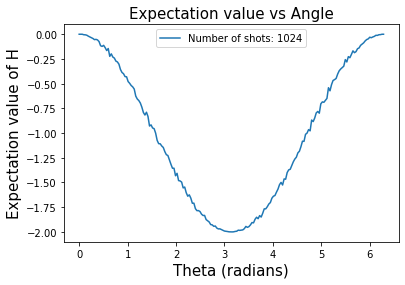

The minimum bound on the lowest eigenvalue of M is E0=-2.0,

The parameter that corresponds to this energy is theta=3.13 Rads


In [7]:
# Now we generate several thetas, and find the best set of parameters

import matplotlib.pyplot as plt

# The number of trials to run
N_shots = 2**10

# Generate theta grid
theta = np.linspace(0.0,2*np.pi,200)
E = np.zeros(len(theta))

# Calculate the expectation value of the Hamiltonian for different theta
for k in range(len(theta)):
    E[k] =  hamiltonian(theta=theta[k],N_shots=N_shots)
    

# Plot the results
plt.title('Expectation value vs Angle',fontsize=15)
plt.ylabel('Expectation value of H',fontsize=15)
plt.xlabel('Theta (radians)',fontsize=15)
plt.plot(theta,E,label='Number of shots: {}'.format(N_shots))
plt.legend()
plt.show()
    

# Determine the lowest bound from varying theta
print('='*100)
print('The minimum bound on the lowest eigenvalue of M is E0={},\n'.format(min(E)))
print('The parameter that corresponds to this energy is theta={:0.2f} Rads'.format(theta[np.argmin(E)]))
print('='*100)